In [ ]:
# TODO: Continuer à travailler la classe pour l'évaluation sur le jeu de test et finir le pipeline
# TODO: Intégrer les métriques du jeu de test

# README

#TODO Ce notebook présente une analyse de données sur les ventes de jeux vidéo. L'objectif est d'explorer les tendances des ventes en fonction de la plateforme, du genre et de la région.

# PRE-REQUIS

Ce bloc contient tout ce qui est nécessaire pour le fonctionnement des expériences.

## Imports & Configurations

In [2]:
import os
import warnings
from time import time
from datetime import datetime

import pandas as pd
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

from constants import ROOT_FOLDER, IMAGE_FOLDER, ARTIFACTS_FOLDER, DATASET_PATH
from constants import SEED, VAL_SIZE, TEST_SIZE, BATCH_SIZE, SAMPLING, INPUT_RESOLUTION

2025-05-02 23:20:13.141256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746220813.163599    8553 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746220813.170160    8553 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746220813.184601    8553 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746220813.184625    8553 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746220813.184626    8553 computation_placer.cc:177] computation placer alr

## Préparation des données

### Chargement du dataset

In [3]:
# Loading the pickle dataset_cleaned used with the previous project as a pandas df
df = pd.read_pickle(DATASET_PATH).drop(columns=["product_name", "description"])
print(f"Dataset shape: {df.shape}")
print(f"Dataset columns: {df.columns}")

# Encode the labels with LabelEncoder
le = LabelEncoder()
le.fit(df["class"])
N_CLASSES = len(le.classes_)
CLASSES = le.classes_.tolist()
print(f"Number of classes: {N_CLASSES}")
print(f"Classes: {CLASSES}")

# Finally transform the class column to the encoded labels
df["class"] = le.transform(df["class"])

Dataset shape: (1050, 2)
Dataset columns: Index(['image', 'class'], dtype='object')
Number of classes: 7
Classes: ['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


### Séparation des données (train/validation/test)

In [4]:
# Splitting the datasets into train, val and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    df["image"],
    df["class"],
    test_size=TEST_SIZE,
    random_state=SEED,
    stratify=df["class"],
    shuffle=True,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=VAL_SIZE, random_state=SEED, stratify=y_temp, shuffle=True
)

# Concat X and y for each set
train = (
    pd.concat([X_train, y_train], axis=1).sample(SAMPLING)
    if SAMPLING
    else pd.concat([X_train, y_train], axis=1)
)
val = (
    pd.concat([X_val, y_val], axis=1).sample(SAMPLING)
    if SAMPLING
    else pd.concat([X_val, y_val], axis=1)
)
test = (
    pd.concat([X_test, y_test], axis=1).sample(SAMPLING)
    if SAMPLING
    else pd.concat([X_test, y_test], axis=1)
)

# Print the shape of each set
print(f"Train shape: {train.shape}")
print(f"Val shape: {val.shape}")
print(f"Test shape: {test.shape}")

Train shape: (32, 2)
Val shape: (32, 2)
Test shape: (32, 2)


In [5]:
train.head(5)

,image,class
64,80e9cb3d2d7f9ff7bc497c34df366d03.jpg,5
549,8a15fa23b8c39ac1c7eaac94cbbe6fc6.jpg,6
907,480d24adbc304a52a4e01e45bf8bbccc.jpg,0
56,24e85c590481a7cedfe66597f253f2b2.jpg,1
550,321f2ab0dd243778c87ac63ace6639f4.jpg,6


In [6]:
val.head(5)

,image,class
791,4676a8f96abb86c5d1dc5b06c7a11d95.jpg,1
204,6775e3b91baa4d368f6d91eb7c24578b.jpg,5
489,5a5bb03499009f35759258263fc834a3.jpg,2
324,a43fbae655e5d13215b9dd65339fa9d4.jpg,2
979,c44a5dc5b5ebe5b3e0535b7c2b7921e4.jpg,0


In [7]:
test.head(5)

,image,class
858,fffa2117a4006d4a848eb7d5b80d4816.jpg,2
188,ffbf3794aa8cb6bb8d3f313d0a549a09.jpg,5
948,c417f408340252f170f05dadf88160d7.jpg,3
1027,362714cbba2f5ae412d2f26bae99a266.jpg,4
875,e56ffc10078972b5f4e7302383db8d72.jpg,4


## Classes et Fonctions

### DataLoader

[ ] ***TODO*** :

In [70]:
# Block DataLoader
from pathlib import PosixPath

class ImageDataset(tf.keras.utils.Sequence):
    def __init__(
        self,
        dataframe: pd.DataFrame,
        image_dir: PosixPath,
        processor = None,
        **kwargs,
    ):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing image file names and labels.
            image_dir (PosixPath): Directory where images are stored.
            processor (AutoImageProcessor, optional): Hugging Face processor for image preprocessing. Defaults to None.
        """
        super().__init__(**kwargs)
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / BATCH_SIZE))

    def __getitem__(self, idx):
        batch_data = self.dataframe.iloc[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
        images = []
        labels = []

        for _, row in batch_data.iterrows():
            img_name = self.image_dir / row[0]  # Assuming image file names are in the first column
            image = Image.open(img_name).convert("RGB")  # Ensure consistent color format
            image = image.resize((INPUT_RESOLUTION[0], INPUT_RESOLUTION[1]), Image.Resampling.BILINEAR)  # Resize to model input size

            label = row[1]  # Assuming labels are in the second column

            if self.processor:
                image = self.processor(image)

            images.append(np.array(image))
            labels.append(label)

        # Convert to TensorFlow tensors
        images = tf.convert_to_tensor(images)
        labels = tf.convert_to_tensor(labels)

        return images, labels

In [77]:
INPUT_RESOLUTION

(224, 224, 3)

In [78]:
class EfficientNetModel(tf.keras.Model):
    def __init__(self, num_classes, input_resolution, weights=None):
        super().__init__()
        self.base_model = EfficientNetB0(**{
            'include_top': True,
            'weights': None,
            'input_shape': INPUT_RESOLUTION,
            'classes': N_CLASSES,
            'classifier_activation': 'softmax'
            }
        )
        self.base_model.load_weights(weights) if weights else None
        self.pooling = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")
        self.fc1 = tf.keras.layers.Dense(1024, activation="relu", name="fc1")
        self.fc2 = tf.keras.layers.Dense(num_classes, activation="softmax", name="predictions")

    def call(self, inputs):
        x = self.base_model(inputs)
        x = self.pooling(x)
        x = self.fc1(x)
        predictions = self.fc2(x)
        return predictions


In [75]:
model = EfficientNetModel(
    num_classes=N_CLASSES,
    input_resolution=INPUT_RESOLUTION,
    weights= ARTIFACTS_FOLDER / "effnet.weights.h5",
)

In [79]:
test_dataset = ImageDataset(
    dataframe=test,
    image_dir=IMAGE_FOLDER,
    processor=preprocess_input,  # Assuming no processor is needed for this model
)

/tmp/ipykernel_8553/300332428.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_name = self.image_dir / row[0]  # Assuming image file names are in the first column
/tmp/ipykernel_8553/300332428.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]  # Assuming labels are in the second column


4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 385ms/step - accuracy: 0.0417 - loss: 2.0999
Test Loss: 2.054971933364868
Test Accuracy: 0.0625
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 375ms/step
                            precision    recall  f1-score   support

                 Baby Care       0.12      0.67      0.20         3
  Beauty and Personal Care       0.00      0.00      0.00         3
                 Computers       0.00      0.00      0.00         8
Home Decor & Festive Needs       0.00      0.00      0.00         4
           Home Furnishing       0.00      0.00      0.00         8
          Kitchen & Dining       0.00      0.00      0.00         3
                   Watches       0.00      0.00      0.00         3

                  accuracy                           0.06        32
                 macro avg       0.02      0.10      0.03        32
              weighted avg       0.01      0.06      0.02        32



/home/hedredo/github/oc_p9/notebook-tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hedredo/github/oc_p9/notebook-tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hedredo/github/oc_p9/notebook-tf/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

<Figure size 1000x800 with 0 Axes>

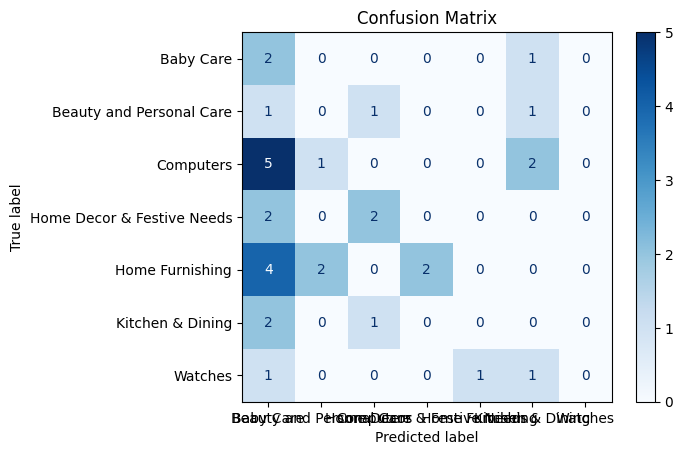

In [80]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
# Generate predictions
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)
# Get true labels
true_labels = test["class"].values
# Generate classification report
report = classification_report(true_labels, predicted_classes, target_names=CLASSES)
print(report)
# Generate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_classes, num_classes=N_CLASSES)
# Plot confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(confusion_matrix=cm.numpy(), display_labels=CLASSES).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Enregistre les paramètres du modèle
model_params = {
    'include_top': False,
    'weights': 'imagenet',
    'input_shape': (224, 224, 3)
}

# Charge le modèle EfficientNetB0
model = EfficientNetB0(**model_params)
# Ajoute les dernières couches denses du modèle
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(N_CLASSES, activation='softmax', name='predictions')(x)

# Crée un modèle à partir des inputs et des outputs
model = Model(inputs=model.input, outputs=predictions)
img = PIL.Image.open(img_test)
img_resized = img.resize((224, 224))
img_preprocessed = preprocess_input(img_resized)
img_batch = np.expand_dims(img_preprocessed, axis=0)
prediction = model.predict(img_batch)
prediction.shape

I0000 00:00:1745666803.165664   38835 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2246 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5
I0000 00:00:1745666808.012181   39239 service.cc:152] XLA service 0x7fa2ac002ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745666808.012247   39239 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-04-26 13:26:48.146253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745666808.828308   39239 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


I0000 00:00:1745666815.847296   39239 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(1, 7)